### Code-3.1: PDE-NN for 2D Unsteady Burgers: Problem 1

Tasks:
    
    1. PDE-NN for 2D unsteady Burgers' equation:
        1.0. Data
        1.1. Geometry & BC
        1.2. Sampling plan
        1.3. PDE-NN 
    2. Optimize PDE-NN: [SGD]
    3. Visualize training dynamic

Purpose:

    1. Study PDE-NN flexibility 

Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyDOE import *
from scipy import pi, exp

import seaborn as sns

## run on CPU...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
tf.compat.v1.disable_eager_execution()

### 1. PDE-NN for 2D unsteady Burgers' equation

    - 2D Burgers' equation PDE :
    - u_t + u*u_x + v*u_y = 1/Re *(u_xx + u_yy)
    - v_t + u*v_x + v*v_y = 1/Re *(v_xx + v_yy)
    
    - Problem 1:
    - u(t,x,y) = 3/4 - 1/(4*(1 + exp(Re*(-t - 4*x + 4*y)/32)))
    - v(t,x,y) = 3/4 + 1/(4*(1 + exp(Re*(-t - 4*x + 4*y)/32)))
    
    - IC : u(0,x,y), v(0,x,y)
    - BC : u(t,x,y), v(t,x,y)   @4 sides [0,1]x[0,1]  

    - Re = ?

#### 1.0. Data

In [3]:
# N/A

#### 1.1. Geometry & BC

In [4]:
# spatial-temporal domain
T = 1.0   #2

# computational boundary
t_l, t_u, x_l, x_u, y_l, y_u = 0, T, 0., 1., 0., 1.
ext = [x_l, x_u, y_l, y_u]

In [5]:
# PDE 
Re = 100

def f_soln(t, x, y):
    r = 1/(4*(1 + tf.math.exp(Re*(-t - 4*x + 4*y)/32)))
    u, v = 3/4 - r, 3/4 + r
    return (u.eval(session=tf.compat.v1.Session()), v.eval(session=tf.compat.v1.Session()))

#### 1.2. Sampling plan

# Training sample = 520251


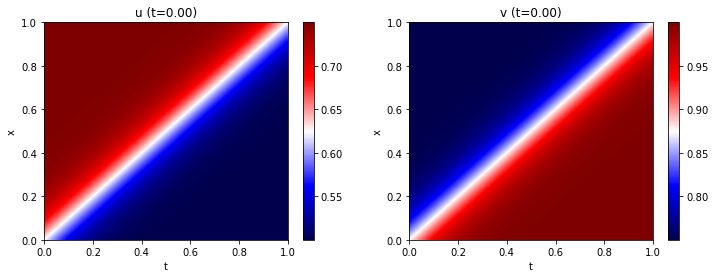

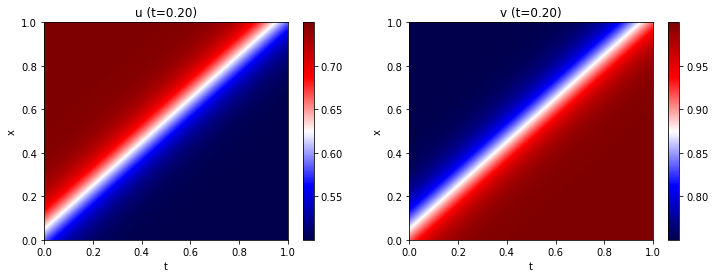

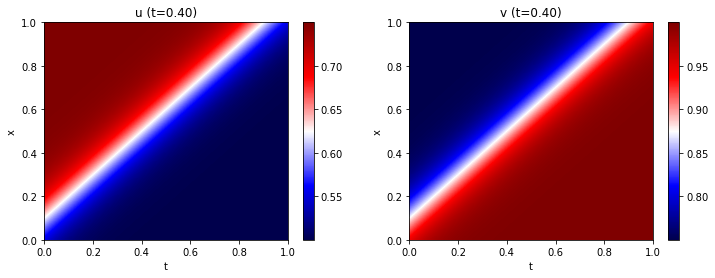

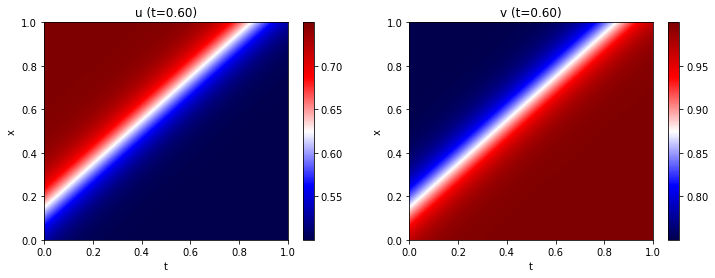

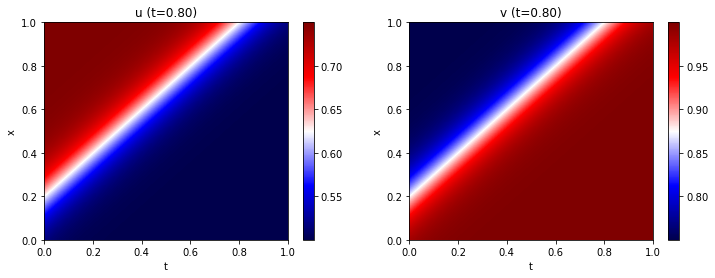

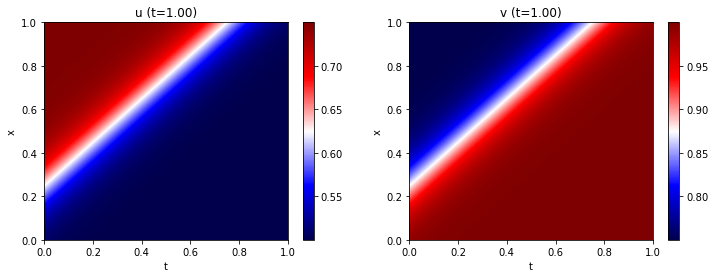

In [6]:
# training sample (t * x * y)
n, n_t = 101, 51
ct = np.linspace(t_l, t_u, n_t)
cx, cy = np.linspace(x_l, x_u, n), np.linspace(y_l, y_u, n)
hx, hy, ht = np.meshgrid(cx, cy, ct)
X_train = np.vstack([ht.flatten(), hx.flatten(), hy.flatten(), np.ones_like(hx.flatten())]).T
u, v = f_soln(X_train[:, 0], X_train[:, 1], X_train[:, 2])
y_train = np.vstack([u, v]).T

print ('# Training sample = %d' %len(y_train))

# visualize train data
for i in [0, 10, 20, 30, 40, 50]:
    t = ct[i]
    ix = (X_train[:, 0] == t)
    fig = plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    _u = y_train[ix, 0].reshape(n, n)
    plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='seismic', extent=ext, aspect='auto');
    plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('u (t=%.2f)'%t);
    ax = plt.subplot(1, 2, 2)
    _v = y_train[ix, 1].reshape(n, n)
    plt.imshow(_v, interpolation='bilinear', origin='lower', cmap='seismic', extent=ext, aspect='auto');
    plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('v (t=%.2f)'%t);

In [7]:
# BC sample (t * n x4)
n_bc, n_t_bc = 125, 25
t = np.linspace(t_l, t_u, n_t_bc)
x, y = np.linspace(x_l, x_u, n_bc), np.linspace(y_l, y_u, n_bc)
X_bc = np.vstack([np.hstack([x.reshape(-1, 1), y_u*np.ones((n_bc, 1)), np.ones((n_bc, 1))]),
                  np.hstack([x.reshape(-1, 1), y_l*np.ones((n_bc, 1)), np.ones((n_bc, 1))]),
                  np.hstack([x_l*np.ones((n_bc, 1)), y.reshape(-1, 1), np.ones((n_bc, 1))]),
                  np.hstack([x_u*np.ones((n_bc, 1)), y.reshape(-1, 1), np.ones((n_bc, 1))])])
X_bc = np.hstack([np.tile(t, n_bc*4).reshape(-1, 1), np.tile(X_bc.T, n_t_bc).T])
u, v = f_soln(X_bc[:, 0], X_bc[:, 1], X_bc[:, 2])
y_bc = np.vstack([u, v]).T
print ('# BC sample = %d' %len(y_bc))

# BC sample = 12500


# IC sample = 10201


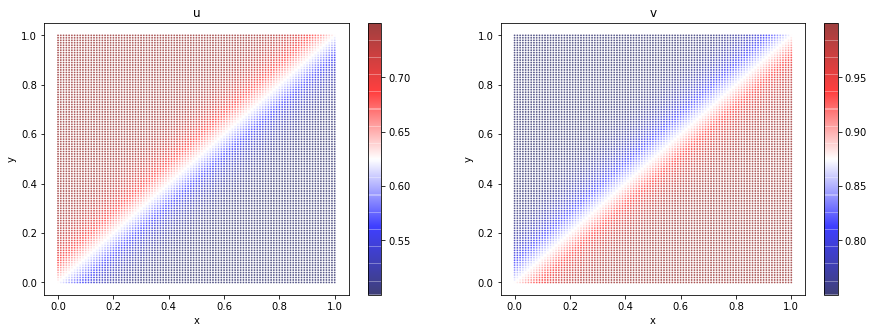

In [8]:
# IC sample (x * y)
n_ic = 101
t = 0.
cx, cy = np.linspace(x_l, x_u, n_ic), np.linspace(y_l, y_u, n_ic)
hx, hy = np.meshgrid(cx, cy)
X_ic = np.vstack([t*np.ones_like(hx.flatten()), hx.flatten(), hy.flatten(), np.ones_like(hx.flatten())]).T
u, v = f_soln(X_ic[:, 0], X_ic[:, 1], X_ic[:, 2])
y_ic = np.vstack([u, v]).T
print ('# IC sample = %d' %len(y_ic))

# visualize train data
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.scatter(X_ic[:, 1], X_ic[:, 2], c=y_ic[:, 0], marker='H', s=1, alpha=.5, cmap='seismic');
plt.title('u'); plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();
ax = plt.subplot(1, 2, 2)
plt.scatter(X_ic[:, 1], X_ic[:, 2], c=y_ic[:, 1], marker='H', s=1, alpha=.5, cmap='seismic');
plt.title('v'); plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();

In [9]:
# evaluation sample
X_eval, y_eval = X_train, y_train

# PDE sample
X_pde, y_pde = X_train, y_train

In [10]:
# define sampling plan
class SamplingPlan(keras.utils.Sequence):
    # sampling plan
    def __init__(self, data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(50, 20, 10),
                 epochs=1000, n_split=10, batch_per_epoch=20):

        self.X, self.y, self.X_ic, self.y_ic, self.X_bc, self.y_bc = data
        self.n, self.n_ic, self.n_bc = len(self.X), len(self.X_ic), len(self.X_bc)
        self.ID, self.ID_ic, self.ID_bc = np.arange(self.n), np.arange(self.n_ic), np.arange(self.n_bc)
        # input parameters
        self.batch_size, self.batch_ic, self.batch_bc = batch_size
        self.batch_per_epoch = batch_per_epoch
        self.n_split = n_split
        self.epochs = epochs
        self._queues()
        # internal variables 
        self.cur_epoch = 0
        self.cur_split = 0
        self.cur_IDs = np.array([], dtype=int)
        self.callback = False
        self.on_epoch_end()
        
    def __len__(self):
        # number of mini batch per epoch
        return self.batch_per_epoch
    
    def __getitem__(self, idx):
        # shuffle & pick batch_size sample
        np.random.shuffle(self.cur_IDs)
        idxs = self.cur_IDs[:self.batch_size]
        batch_X, batch_y = self.X[idxs], self.y[idxs]
        # pick ic sample
        np.random.shuffle(self.ID_ic)
        idxs = self.ID_ic[:self.batch_ic]
        batch_X_ic, batch_y_ic = self.X_ic[idxs], self.y_ic[idxs]            
        # pick bc sample 
        np.random.shuffle(self.ID_bc)
        idxs = self.ID_bc[:self.batch_bc]
        batch_X_bc, batch_y_bc = self.X_bc[idxs], self.y_bc[idxs]
        # to include ic & bc sample
        batch_X, batch_y = np.vstack([batch_X, batch_X_ic, batch_X_bc]), np.vstack([batch_y, batch_y_ic, batch_y_bc])        
        return (batch_X, batch_y)
    
    def on_epoch_end(self):
        if self.cur_split < self.n_split:
            # check training loss criteria
            if self.callback:
                self._check_loss()
            # updates indexes after certain epoch
            if (self.cur_epoch == self.queue_epoch[self.cur_split]):
                self.cur_IDs = np.concatenate((self.cur_IDs, self.queue_n[self.cur_split]))
                self.cur_split += 1
                print ('Increase sample size @epoch-%d: n = %d'%(self.cur_epoch+1, len(self.cur_IDs)))
                if self.callback:
                    # reset learning rate
                    self.lr_schedular._reset()
                    self.lr_monitor._reset()
            self.cur_epoch += 1
        
    def _queues(self):
        # decide when to increase sample & which 
        self.queue_n = np.array_split(self.ID, self.n_split)
        self.queue_epoch = [a[0] for a in np.array_split(np.arange(self.epochs), self.n_split)]
        
    def _check_loss(self):
        if self.lr_monitor.fall_below:
            self.queue_epoch = [q - (self.queue_epoch[self.cur_split] - self.cur_epoch) if q >= self.queue_epoch[self.cur_split]
                                else q for q in self.queue_epoch]
    
    def lr_schedule(self, lr_schedular, lr_monitor):
        # lr schedule
        self.callback = True
        self.lr_schedular = lr_schedular
        self.lr_monitor = lr_monitor
        

#### 1.3. PDE-NN

In [11]:
# specify FF-PINN
def create_nn(ff, n_ffs, sigma, lmbda, n_nodes, acf, lr_int):
    # input layers -> split into (t, x, y, z)
    inputs = layers.Input(shape=(4,))
    t, x, y, z = layers.Lambda( lambda k: tf.split(k, num_or_size_splits=4, axis=1))(inputs)

    # features mapping
    initializer_ff = tf.keras.initializers.TruncatedNormal(stddev=sigma)  # features initializer

    if (ff == 'RF'):
        hidden_f0 = layers.Dense(n_ffs, activation='linear', use_bias=False, trainable=False, kernel_initializer=initializer_ff)(layers.Concatenate()([t, x, y]))
        hidden_sin, hidden_cos = tf.math.sin(2*tf.constant(pi)*hidden_f0), tf.math.cos(2*tf.constant(pi)*hidden_f0)
        hidden_ff = layers.Concatenate()([hidden_sin, hidden_cos])
    
    if (ff == 'FF'):
        hidden_f0 = layers.Dense(n_ffs, activation='linear', use_bias=False, kernel_initializer=initializer_ff)(layers.Concatenate()([t, x, y]))
        hidden_sin, hidden_cos = tf.math.sin(2*tf.constant(pi)*hidden_f0), tf.math.cos(2*tf.constant(pi)*hidden_f0)
        hidden_ff = layers.Concatenate()([hidden_sin, hidden_cos])
        
    if (ff == 'SF') or (ff == 'SIREN'):
        hidden_f0 = layers.Dense(n_ffs*2, activation='linear', kernel_initializer=initializer_ff)(layers.Concatenate()([t, x, y]))
        hidden_ff = tf.math.sin(2*tf.constant(pi)*hidden_f0)

    if (ff == 'HF'):
        hidden_ff = layers.Dense(n_ffs*2, activation=acf, kernel_initializer=initializer_ff)(layers.Concatenate()([t, x, y]))

    # hidden layers
    if (ff == 'SIREN'):
        initializer = tf.keras.initializers.HeUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_2)
    else:
        initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_2)

    # split layers - u
    if (ff == 'SIREN'):
        hidden_u1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_u2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_u1)
        hidden_ul = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_u2)
    else:
        hidden_u1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_u2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_u1)
        hidden_ul = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_u2)

    # split layers - v
    if (ff == 'SIREN'):
        hidden_v1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_v2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_v1)
        hidden_vl = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_v2)
    else:
        hidden_v1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_v2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_v1)
        hidden_vl = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_v2)        
        
    # output layers
    u = layers.Dense(1, use_bias=False, name="U")(hidden_ul)
    v = layers.Dense(1, use_bias=False, name="V")(hidden_vl)
    outputs = layers.Concatenate()([u, v])    

    # axillary PDE outputs
    u_t, v_t = K.gradients(u, t)[0], K.gradients(v, t)[0]
    u_x, u_y = K.gradients(u, x)[0], K.gradients(u, y)[0]
    v_x, v_y = K.gradients(v, x)[0], K.gradients(v, y)[0]
    u_xx, u_yy = K.gradients(u_x, x)[0], K.gradients(u_y, y)[0]
    v_xx, v_yy = K.gradients(v_x, x)[0], K.gradients(v_y, y)[0]    

    # PDE (2D Burgers' equation):
    # u_t + u*u_x + v*u_y = 1/Re *(u_xx + u_yy)
    # v_t + u*v_x + v*v_y = 1/Re *(v_xx + v_yy)
    pde_u = u_t + u*u_x + v*u_y - 1/Re *(u_xx + u_yy)
    pde_v = v_t + u*v_x + v*v_y - 1/Re *(v_xx + v_yy)
    pde_mse_u = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde_u), predictions=pde_u)
    pde_mse_v = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde_v), predictions=pde_v)
    pde_mse = pde_mse_u + pde_mse_v
    pde_mse = pde_mse / lmbda

    # initial & boundary conditions: 
    t_u, t_v = tf_bc(t, x, y)  # ground truth
    mse_u = tf.compat.v1.losses.mean_squared_error(labels=t_u, predictions=u)
    mse_v = tf.compat.v1.losses.mean_squared_error(labels=t_v, predictions=v)
    
    # IC
    _ic = tf.equal(t, t_l)
    ic_mse_u = tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(t_u, _ic), predictions=tf.boolean_mask(u, _ic))
    ic_mse_v = tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(t_v, _ic), predictions=tf.boolean_mask(v, _ic))
    ic_mse = ic_mse_u + ic_mse_v
    
    # BC
    _bc = ( tf.equal(y, y_u) | tf.equal(y, y_l) | tf.equal(x, x_u) | tf.equal(x, x_l) )
    bc_mse_u = tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(t_u, _bc), predictions=tf.boolean_mask(u, _bc))
    bc_mse_v = tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(t_v, _bc), predictions=tf.boolean_mask(v, _bc))
    bc_mse = bc_mse_u + bc_mse_v
    
    
    # initiate model
    nn = models.Model(inputs=inputs, outputs=outputs)

    # optimizer
    optimizer = tf.keras.optimizers.Adam(lr_int)

    # compile model with [?] loss
    nn.compile(loss = compute_physics_loss(pde_mse, bc_mse, ic_mse),
               optimizer = optimizer,
               metrics = [compute_u_loss(mse_u), compute_v_loss(mse_v), 
                          compute_ic_loss(ic_mse), compute_bc_loss(bc_mse), compute_pde_loss(pde_mse)])

    # pathway to NN inside variables
    insiders = [u, v, pde_u, pde_v, pde_mse, bc_mse, ic_mse]
    eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function

    return (nn, eval_ins)


# f: IC/BC
def tf_bc(t, x, y):
    r = 1/(4*(1 + tf.math.exp(Re*(-t - 4*x + 4*y)/32)))
    u, v = 3/4 - r, 3/4 + r
    return (u, v)

In [12]:
# loss functions
# define loss function (data loss)
def compute_data_loss(z):
    def data_loss(y_true, y_pred):
        labels = tf.equal(z, 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))
    return data_loss

# define loss function (u loss)
def compute_u_loss(mse_u):
    def u_loss(y_true, y_pred): return mse_u
    return u_loss # return a function

# define loss function (v loss)
def compute_v_loss(mse_v):
    def v_loss(y_true, y_pred): return mse_v
    return v_loss # return a function

# define loss function (Physics loss)
def compute_physics_loss(pde_mse, bc_mse, ic_mse):
    def physics_loss(y_true, y_pred): return pde_mse + bc_mse + ic_mse
    return physics_loss # return a function

# define loss function (IC loss)
def compute_ic_loss(ic_mse):
    def ic_loss(y_true, y_pred): return ic_mse
    return ic_loss # return a function

# define loss function (BC loss)
def compute_bc_loss(bc_mse):
    def bc_loss(y_true, y_pred): return bc_mse
    return bc_loss # return a function

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function


# callback: training (prediction & residual) history
class TrainingHistory(Callback):
    def __init__(self, eval_ins, data):
        super(Callback, self).__init__()
        self.data = data
        self.eval_ins = eval_ins
        self.e_hist = []
        self.u_hist = []
        self.v_hist = []
        self.pde_u_hist = []
        self.pde_v_hist = []
        self.pde_mse_hist = []
        self.bc_mse_hist = []
        self.ic_mse_hist = []
    def on_epoch_end(self, epoch, logs={}):
        e = epoch + 1
        if (e < 10) | ((e < 100) & (e%10 == 0)) | ((e < 1000) & (e%100 == 0)) | (e%1000 == 0):
            data = self.data
            u, v, pde_u, pde_v, pde_mse, bc_mse, ic_mse = self.eval_ins(data)
            self.e_hist.append(e)
            self.u_hist.append(u)
            self.v_hist.append(v)
            self.pde_u_hist.append(pde_u)
            self.pde_v_hist.append(pde_v)
            self.pde_mse_hist.append(pde_mse)
            self.bc_mse_hist.append(bc_mse)
            self.ic_mse_hist.append(ic_mse)
            
            
# callback: weights history           
class WeightsHistory(Callback):
    def __init__(self):
        super(Callback, self).__init__()
        self.w_hist = []
    def on_epoch_end(self, epoch, logs={}):
        ws = np.array([])
        for _w in self.model.get_weights() : ws = np.append(ws, _w.flatten())
        self.w_hist.append(ws) 

### 2. Optimize D-PDE-NN: [SGD]

In [13]:
# initiate NN model (& pathway to internal values)
n_ffs = 32
lmbda = 1e0

ff = 'SIREN'
sigma = 1.

nn, eval_ins = create_nn(ff, n_ffs, sigma, lmbda, n_nodes = 20, acf = 'tanh', lr_int = 0.001)

# first pass
u_0, v_0, pde_u_0, pde_v_0, pde_mse_0, bc_mse_0, ic_mse_0 = eval_ins(X_eval)   
    
nn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3)            0           lambda[0][0]                     
                                                                 lambda[0][1]                     
                                                                 lambda[0][2]                     
_______________________________________________________________________________________

In [14]:
# PINN training setting: EPOCH, learning rate & sampling strategy
EPOCH = 1000
BPE = 100
LR = 5e-3
DGEN = SamplingPlan(data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(450, 40, 10),
                    epochs=EPOCH, n_split=1, batch_per_epoch=BPE)

# callback setting: learning rate schedule & training history
lr_sched = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=1e-6)
tr_hist = TrainingHistory(eval_ins, X_eval)
ws_hist = WeightsHistory()
callbacks_list = [lr_sched, tr_hist, ws_hist]

# time it
t0 = time()

# train NN model
K.set_value(nn.optimizer.lr, LR)  # set learning rate
history = nn.fit(DGEN, epochs=EPOCH, verbose=2, callbacks=callbacks_list)

print ("...\nRunning time: %d mins %d secs!" %(int(time()-t0)/60, np.remainder(int(time()-t0), 60)))

Increase sample size @epoch-1: n = 520251
Epoch 1/1000
100/100 - 8s - loss: 24.1811 - u_loss: 0.2899 - v_loss: 0.4419 - ic_loss: 0.7449 - bc_loss: 0.7669 - pde_loss: 22.6693
Epoch 2/1000
100/100 - 8s - loss: 1.4675 - u_loss: 0.0953 - v_loss: 0.2139 - ic_loss: 0.3064 - bc_loss: 0.3118 - pde_loss: 0.8493
Epoch 3/1000
100/100 - 9s - loss: 0.7184 - u_loss: 0.0352 - v_loss: 0.1008 - ic_loss: 0.1319 - bc_loss: 0.1375 - pde_loss: 0.4490
Epoch 4/1000
100/100 - 8s - loss: 0.4000 - u_loss: 0.0186 - v_loss: 0.0456 - ic_loss: 0.0600 - bc_loss: 0.0672 - pde_loss: 0.2727
Epoch 5/1000
100/100 - 8s - loss: 0.2506 - u_loss: 0.0134 - v_loss: 0.0238 - ic_loss: 0.0342 - bc_loss: 0.0409 - pde_loss: 0.1755
Epoch 6/1000
100/100 - 8s - loss: 0.1768 - u_loss: 0.0117 - v_loss: 0.0159 - ic_loss: 0.0251 - bc_loss: 0.0309 - pde_loss: 0.1208
Epoch 7/1000
100/100 - 8s - loss: 0.1369 - u_loss: 0.0111 - v_loss: 0.0133 - ic_loss: 0.0221 - bc_loss: 0.0276 - pde_loss: 0.0873
Epoch 8/1000
100/100 - 8s - loss: 0.1120 - u_l

Epoch 64/1000
100/100 - 3s - loss: 0.0130 - u_loss: 0.0036 - v_loss: 0.0036 - ic_loss: 0.0013 - bc_loss: 0.0081 - pde_loss: 0.0035
Epoch 65/1000
100/100 - 3s - loss: 0.0114 - u_loss: 0.0035 - v_loss: 0.0035 - ic_loss: 0.0011 - bc_loss: 0.0068 - pde_loss: 0.0035
Epoch 66/1000
100/100 - 3s - loss: 0.0106 - u_loss: 0.0032 - v_loss: 0.0032 - ic_loss: 9.4978e-04 - bc_loss: 0.0065 - pde_loss: 0.0032
Epoch 67/1000
100/100 - 2s - loss: 0.0101 - u_loss: 0.0029 - v_loss: 0.0029 - ic_loss: 9.1716e-04 - bc_loss: 0.0059 - pde_loss: 0.0033
Epoch 68/1000
100/100 - 2s - loss: 0.0089 - u_loss: 0.0026 - v_loss: 0.0026 - ic_loss: 7.1200e-04 - bc_loss: 0.0051 - pde_loss: 0.0031
Epoch 69/1000
100/100 - 3s - loss: 0.0079 - u_loss: 0.0022 - v_loss: 0.0022 - ic_loss: 5.4731e-04 - bc_loss: 0.0043 - pde_loss: 0.0031
Epoch 70/1000
100/100 - 10s - loss: 0.0071 - u_loss: 0.0019 - v_loss: 0.0019 - ic_loss: 4.7875e-04 - bc_loss: 0.0037 - pde_loss: 0.0030
Epoch 71/1000
100/100 - 2s - loss: 0.0058 - u_loss: 0.0014 - v

Epoch 119/1000
100/100 - 3s - loss: 1.2636e-04 - u_loss: 7.5831e-06 - v_loss: 8.0120e-06 - ic_loss: 1.4850e-05 - bc_loss: 1.6526e-05 - pde_loss: 9.4988e-05
Epoch 120/1000
100/100 - 2s - loss: 1.4693e-04 - u_loss: 1.2692e-05 - v_loss: 1.3052e-05 - ic_loss: 2.3200e-05 - bc_loss: 2.6599e-05 - pde_loss: 9.7126e-05
Epoch 121/1000
100/100 - 2s - loss: 1.6885e-04 - u_loss: 1.5572e-05 - v_loss: 1.8514e-05 - ic_loss: 3.1867e-05 - bc_loss: 3.5396e-05 - pde_loss: 1.0158e-04
Epoch 122/1000
100/100 - 3s - loss: 1.3658e-04 - u_loss: 1.0625e-05 - v_loss: 1.2489e-05 - ic_loss: 2.1757e-05 - bc_loss: 2.3762e-05 - pde_loss: 9.1059e-05
Epoch 123/1000
100/100 - 2s - loss: 1.3788e-04 - u_loss: 1.1861e-05 - v_loss: 1.5100e-05 - ic_loss: 2.5186e-05 - bc_loss: 2.7660e-05 - pde_loss: 8.5035e-05
Epoch 124/1000
100/100 - 2s - loss: 1.9428e-04 - u_loss: 2.0264e-05 - v_loss: 2.5780e-05 - ic_loss: 4.1302e-05 - bc_loss: 4.6759e-05 - pde_loss: 1.0622e-04
Epoch 125/1000
100/100 - 3s - loss: 1.7695e-04 - u_loss: 2.3661e

Epoch 172/1000
100/100 - 3s - loss: 1.4101e-04 - u_loss: 1.5210e-05 - v_loss: 2.0357e-05 - ic_loss: 3.6342e-05 - bc_loss: 3.6717e-05 - pde_loss: 6.7956e-05
Epoch 173/1000
100/100 - 2s - loss: 3.3196e-05 - u_loss: 2.5298e-06 - v_loss: 3.4638e-06 - ic_loss: 6.3869e-06 - bc_loss: 6.5119e-06 - pde_loss: 2.0297e-05
Epoch 174/1000
100/100 - 2s - loss: 8.0275e-05 - u_loss: 5.7848e-06 - v_loss: 9.5201e-06 - ic_loss: 1.4792e-05 - bc_loss: 1.4748e-05 - pde_loss: 5.0735e-05
Epoch 175/1000
100/100 - 2s - loss: 8.1800e-05 - u_loss: 7.9089e-06 - v_loss: 1.0681e-05 - ic_loss: 1.7763e-05 - bc_loss: 1.7793e-05 - pde_loss: 4.6244e-05
Epoch 176/1000
100/100 - 2s - loss: 1.5268e-05 - u_loss: 9.6436e-07 - v_loss: 1.1193e-06 - ic_loss: 1.9535e-06 - bc_loss: 2.3652e-06 - pde_loss: 1.0949e-05
Epoch 177/1000
100/100 - 2s - loss: 1.4591e-05 - u_loss: 9.8119e-07 - v_loss: 1.1401e-06 - ic_loss: 2.1285e-06 - bc_loss: 2.1687e-06 - pde_loss: 1.0294e-05
Epoch 178/1000
100/100 - 2s - loss: 5.4287e-05 - u_loss: 5.5924e

Epoch 225/1000
100/100 - 3s - loss: 3.6199e-06 - u_loss: 1.8130e-07 - v_loss: 2.6246e-07 - ic_loss: 3.7109e-07 - bc_loss: 5.4592e-07 - pde_loss: 2.7029e-06
Epoch 226/1000
100/100 - 2s - loss: 3.4945e-06 - u_loss: 2.0001e-07 - v_loss: 2.6842e-07 - ic_loss: 3.9120e-07 - bc_loss: 5.2272e-07 - pde_loss: 2.5806e-06
Epoch 227/1000
100/100 - 2s - loss: 3.6931e-06 - u_loss: 2.0919e-07 - v_loss: 2.9942e-07 - ic_loss: 4.6193e-07 - bc_loss: 6.2167e-07 - pde_loss: 2.6095e-06
Epoch 228/1000
100/100 - 3s - loss: 3.3637e-06 - u_loss: 1.9107e-07 - v_loss: 2.5403e-07 - ic_loss: 3.6857e-07 - bc_loss: 5.4350e-07 - pde_loss: 2.4516e-06
Epoch 229/1000
100/100 - 2s - loss: 3.8489e-06 - u_loss: 2.2683e-07 - v_loss: 3.7148e-07 - ic_loss: 5.5076e-07 - bc_loss: 6.2740e-07 - pde_loss: 2.6707e-06
Epoch 230/1000
100/100 - 3s - loss: 4.8321e-06 - u_loss: 3.2279e-07 - v_loss: 6.6385e-07 - ic_loss: 9.4213e-07 - bc_loss: 1.0546e-06 - pde_loss: 2.8353e-06
Epoch 231/1000
100/100 - 2s - loss: 1.0530e-05 - u_loss: 8.7296e

Epoch 278/1000
100/100 - 2s - loss: 6.9717e-07 - u_loss: 3.7843e-08 - v_loss: 4.2134e-08 - ic_loss: 6.7582e-08 - bc_loss: 1.0910e-07 - pde_loss: 5.2049e-07
Epoch 279/1000
100/100 - 3s - loss: 6.6995e-07 - u_loss: 3.7945e-08 - v_loss: 3.8621e-08 - ic_loss: 6.3254e-08 - bc_loss: 1.0245e-07 - pde_loss: 5.0425e-07
Epoch 280/1000
100/100 - 3s - loss: 6.6001e-07 - u_loss: 4.0279e-08 - v_loss: 4.3644e-08 - ic_loss: 7.2700e-08 - bc_loss: 1.0543e-07 - pde_loss: 4.8188e-07
Epoch 281/1000
100/100 - 2s - loss: 6.7310e-07 - u_loss: 3.8024e-08 - v_loss: 4.7914e-08 - ic_loss: 7.5321e-08 - bc_loss: 1.1238e-07 - pde_loss: 4.8539e-07
Epoch 282/1000
100/100 - 2s - loss: 6.7133e-07 - u_loss: 4.5433e-08 - v_loss: 5.6972e-08 - ic_loss: 9.2470e-08 - bc_loss: 1.1782e-07 - pde_loss: 4.6105e-07
Epoch 283/1000
100/100 - 3s - loss: 6.2266e-07 - u_loss: 3.7400e-08 - v_loss: 4.1274e-08 - ic_loss: 7.2294e-08 - bc_loss: 9.7269e-08 - pde_loss: 4.5310e-07
Epoch 284/1000
100/100 - 2s - loss: 5.9001e-07 - u_loss: 3.6719e

Epoch 331/1000
100/100 - 2s - loss: 3.2743e-07 - u_loss: 2.8778e-08 - v_loss: 3.2369e-08 - ic_loss: 6.0123e-08 - bc_loss: 5.9945e-08 - pde_loss: 2.0736e-07
Epoch 332/1000
100/100 - 2s - loss: 3.4251e-07 - u_loss: 3.2960e-08 - v_loss: 4.2446e-08 - ic_loss: 7.9608e-08 - bc_loss: 7.5196e-08 - pde_loss: 1.8771e-07
Epoch 333/1000
100/100 - 3s - loss: 1.1733e-06 - u_loss: 1.2398e-07 - v_loss: 2.0622e-07 - ic_loss: 3.4919e-07 - bc_loss: 2.9893e-07 - pde_loss: 5.2515e-07
Epoch 334/1000
100/100 - 2s - loss: 5.9823e-07 - u_loss: 4.9713e-08 - v_loss: 9.2526e-08 - ic_loss: 1.3829e-07 - bc_loss: 1.4359e-07 - pde_loss: 3.1636e-07
Epoch 335/1000
100/100 - 3s - loss: 6.1277e-06 - u_loss: 6.9368e-07 - v_loss: 1.4677e-06 - ic_loss: 2.2498e-06 - bc_loss: 2.0107e-06 - pde_loss: 1.8671e-06
Epoch 336/1000
100/100 - 3s - loss: 1.4013e-06 - u_loss: 1.5057e-07 - v_loss: 1.7672e-07 - ic_loss: 3.4769e-07 - bc_loss: 3.0042e-07 - pde_loss: 7.5321e-07
Epoch 337/1000
100/100 - 3s - loss: 3.0755e-07 - u_loss: 2.5524e

Epoch 384/1000
100/100 - 3s - loss: 4.3970e-07 - u_loss: 5.1360e-08 - v_loss: 8.6143e-08 - ic_loss: 1.3974e-07 - bc_loss: 1.3271e-07 - pde_loss: 1.6724e-07
Epoch 385/1000
100/100 - 2s - loss: 4.7568e-07 - u_loss: 5.3933e-08 - v_loss: 9.1825e-08 - ic_loss: 1.5662e-07 - bc_loss: 1.3819e-07 - pde_loss: 1.8088e-07
Epoch 386/1000
100/100 - 2s - loss: 5.8320e-07 - u_loss: 7.2526e-08 - v_loss: 1.1478e-07 - ic_loss: 1.9028e-07 - bc_loss: 1.7088e-07 - pde_loss: 2.2204e-07
Epoch 387/1000
100/100 - 3s - loss: 7.3225e-07 - u_loss: 8.0839e-08 - v_loss: 1.4195e-07 - ic_loss: 2.2797e-07 - bc_loss: 2.0040e-07 - pde_loss: 3.0388e-07
Epoch 388/1000
100/100 - 2s - loss: 2.3121e-06 - u_loss: 2.5818e-07 - v_loss: 5.6775e-07 - ic_loss: 8.3428e-07 - bc_loss: 7.9492e-07 - pde_loss: 6.8294e-07
Epoch 389/1000
100/100 - 2s - loss: 2.1895e-07 - u_loss: 2.0747e-08 - v_loss: 2.3927e-08 - ic_loss: 4.7054e-08 - bc_loss: 4.5018e-08 - pde_loss: 1.2687e-07
Epoch 390/1000
100/100 - 3s - loss: 1.0604e-07 - u_loss: 7.2044e

Epoch 437/1000
100/100 - 3s - loss: 1.3553e-07 - u_loss: 1.3548e-08 - v_loss: 2.0862e-08 - ic_loss: 3.4749e-08 - bc_loss: 3.4763e-08 - pde_loss: 6.6016e-08
Epoch 438/1000
100/100 - 2s - loss: 4.2651e-07 - u_loss: 5.0964e-08 - v_loss: 8.1747e-08 - ic_loss: 1.3682e-07 - bc_loss: 1.2201e-07 - pde_loss: 1.6768e-07
Epoch 439/1000
100/100 - 3s - loss: 1.2119e-07 - u_loss: 1.0593e-08 - v_loss: 1.5500e-08 - ic_loss: 2.6551e-08 - bc_loss: 2.7960e-08 - pde_loss: 6.6679e-08
Epoch 440/1000
100/100 - 2s - loss: 8.5028e-08 - u_loss: 7.0645e-09 - v_loss: 1.0877e-08 - ic_loss: 1.8005e-08 - bc_loss: 1.9280e-08 - pde_loss: 4.7743e-08
Epoch 441/1000
100/100 - 3s - loss: 8.6440e-08 - u_loss: 6.9876e-09 - v_loss: 1.0905e-08 - ic_loss: 1.8146e-08 - bc_loss: 1.8182e-08 - pde_loss: 5.0112e-08
Epoch 442/1000
100/100 - 3s - loss: 1.0946e-07 - u_loss: 9.4722e-09 - v_loss: 1.5942e-08 - ic_loss: 2.5520e-08 - bc_loss: 2.6630e-08 - pde_loss: 5.7306e-08
Epoch 443/1000
100/100 - 3s - loss: 9.7598e-08 - u_loss: 8.2692e

Epoch 490/1000
100/100 - 2s - loss: 4.5067e-08 - u_loss: 2.5991e-09 - v_loss: 3.7133e-09 - ic_loss: 6.6208e-09 - bc_loss: 7.8319e-09 - pde_loss: 3.0614e-08
Epoch 491/1000
100/100 - 2s - loss: 4.3500e-08 - u_loss: 2.4059e-09 - v_loss: 3.0097e-09 - ic_loss: 5.8160e-09 - bc_loss: 6.8330e-09 - pde_loss: 3.0851e-08
Epoch 492/1000
100/100 - 3s - loss: 5.2212e-08 - u_loss: 3.6253e-09 - v_loss: 5.6653e-09 - ic_loss: 9.3031e-09 - bc_loss: 1.0765e-08 - pde_loss: 3.2144e-08
Epoch 493/1000
100/100 - 3s - loss: 5.7929e-08 - u_loss: 3.9005e-09 - v_loss: 7.1927e-09 - ic_loss: 1.1487e-08 - bc_loss: 1.2200e-08 - pde_loss: 3.4241e-08
Epoch 494/1000
100/100 - 2s - loss: 5.5110e-08 - u_loss: 4.0768e-09 - v_loss: 5.5624e-09 - ic_loss: 9.8515e-09 - bc_loss: 1.1077e-08 - pde_loss: 3.4181e-08
Epoch 495/1000
100/100 - 3s - loss: 4.8929e-08 - u_loss: 3.2849e-09 - v_loss: 4.6310e-09 - ic_loss: 8.0913e-09 - bc_loss: 9.0696e-09 - pde_loss: 3.1768e-08
Epoch 496/1000
100/100 - 3s - loss: 8.9096e-08 - u_loss: 8.3441e

Epoch 543/1000
100/100 - 2s - loss: 3.4120e-08 - u_loss: 2.0648e-09 - v_loss: 2.2602e-09 - ic_loss: 4.3391e-09 - bc_loss: 5.6832e-09 - pde_loss: 2.4098e-08
Epoch 544/1000
100/100 - 3s - loss: 3.2227e-08 - u_loss: 1.7074e-09 - v_loss: 2.1180e-09 - ic_loss: 3.8751e-09 - bc_loss: 5.0933e-09 - pde_loss: 2.3259e-08
Epoch 545/1000
100/100 - 2s - loss: 3.3552e-08 - u_loss: 1.8879e-09 - v_loss: 2.4204e-09 - ic_loss: 4.4248e-09 - bc_loss: 5.5740e-09 - pde_loss: 2.3553e-08
Epoch 546/1000
100/100 - 2s - loss: 3.4369e-08 - u_loss: 2.1123e-09 - v_loss: 2.8160e-09 - ic_loss: 5.0703e-09 - bc_loss: 5.9406e-09 - pde_loss: 2.3359e-08
Epoch 547/1000
100/100 - 3s - loss: 3.0661e-08 - u_loss: 1.4442e-09 - v_loss: 1.6094e-09 - ic_loss: 3.2165e-09 - bc_loss: 4.5008e-09 - pde_loss: 2.2943e-08
Epoch 548/1000
100/100 - 3s - loss: 3.9792e-08 - u_loss: 2.4578e-09 - v_loss: 4.2232e-09 - ic_loss: 6.9012e-09 - bc_loss: 7.5673e-09 - pde_loss: 2.5323e-08
Epoch 549/1000
100/100 - 3s - loss: 4.5966e-08 - u_loss: 3.4942e

Epoch 596/1000
100/100 - 2s - loss: 2.7104e-08 - u_loss: 1.1711e-09 - v_loss: 1.5638e-09 - ic_loss: 2.8903e-09 - bc_loss: 4.3153e-09 - pde_loss: 1.9899e-08
Epoch 597/1000
100/100 - 3s - loss: 2.6422e-08 - u_loss: 1.2290e-09 - v_loss: 1.4629e-09 - ic_loss: 2.8880e-09 - bc_loss: 3.9011e-09 - pde_loss: 1.9633e-08
Epoch 598/1000
100/100 - 3s - loss: 2.5742e-08 - u_loss: 1.2675e-09 - v_loss: 1.2976e-09 - ic_loss: 2.7555e-09 - bc_loss: 3.8913e-09 - pde_loss: 1.9095e-08
Epoch 599/1000
100/100 - 2s - loss: 2.5414e-08 - u_loss: 1.2229e-09 - v_loss: 1.0753e-09 - ic_loss: 2.4805e-09 - bc_loss: 3.5939e-09 - pde_loss: 1.9339e-08
Epoch 600/1000
100/100 - 9s - loss: 2.4795e-08 - u_loss: 9.8405e-10 - v_loss: 1.0987e-09 - ic_loss: 2.1961e-09 - bc_loss: 3.3111e-09 - pde_loss: 1.9288e-08
Epoch 601/1000
100/100 - 3s - loss: 2.5260e-08 - u_loss: 1.1820e-09 - v_loss: 1.1840e-09 - ic_loss: 2.5719e-09 - bc_loss: 3.6000e-09 - pde_loss: 1.9088e-08
Epoch 602/1000
100/100 - 2s - loss: 2.4837e-08 - u_loss: 9.8118e

Epoch 649/1000
100/100 - 3s - loss: 2.2005e-08 - u_loss: 7.5229e-10 - v_loss: 9.0019e-10 - ic_loss: 1.8934e-09 - bc_loss: 2.8369e-09 - pde_loss: 1.7275e-08
Epoch 650/1000
100/100 - 2s - loss: 2.2263e-08 - u_loss: 8.3398e-10 - v_loss: 8.3136e-10 - ic_loss: 1.7990e-09 - bc_loss: 2.7694e-09 - pde_loss: 1.7694e-08
Epoch 651/1000
100/100 - 3s - loss: 2.3130e-08 - u_loss: 8.5470e-10 - v_loss: 1.0469e-09 - ic_loss: 2.1095e-09 - bc_loss: 3.2577e-09 - pde_loss: 1.7763e-08
Epoch 652/1000
100/100 - 3s - loss: 2.3295e-08 - u_loss: 9.1976e-10 - v_loss: 1.1257e-09 - ic_loss: 2.2352e-09 - bc_loss: 3.3816e-09 - pde_loss: 1.7678e-08
Epoch 653/1000
100/100 - 2s - loss: 2.2349e-08 - u_loss: 8.1596e-10 - v_loss: 9.0358e-10 - ic_loss: 1.9406e-09 - bc_loss: 2.9163e-09 - pde_loss: 1.7492e-08
Epoch 654/1000
100/100 - 2s - loss: 2.1945e-08 - u_loss: 7.6772e-10 - v_loss: 7.4957e-10 - ic_loss: 1.7235e-09 - bc_loss: 2.7407e-09 - pde_loss: 1.7481e-08
Epoch 655/1000
100/100 - 3s - loss: 2.2520e-08 - u_loss: 7.8873e

Epoch 702/1000
100/100 - 2s - loss: 2.0381e-08 - u_loss: 6.8663e-10 - v_loss: 6.4525e-10 - ic_loss: 1.5145e-09 - bc_loss: 2.4551e-09 - pde_loss: 1.6411e-08
Epoch 703/1000
100/100 - 3s - loss: 2.0728e-08 - u_loss: 7.0488e-10 - v_loss: 6.6661e-10 - ic_loss: 1.6022e-09 - bc_loss: 2.4755e-09 - pde_loss: 1.6651e-08
Epoch 704/1000
100/100 - 3s - loss: 2.0383e-08 - u_loss: 6.9270e-10 - v_loss: 6.1936e-10 - ic_loss: 1.4989e-09 - bc_loss: 2.4530e-09 - pde_loss: 1.6431e-08
Epoch 705/1000
100/100 - 2s - loss: 2.0760e-08 - u_loss: 6.2922e-10 - v_loss: 5.9121e-10 - ic_loss: 1.3923e-09 - bc_loss: 2.5226e-09 - pde_loss: 1.6845e-08
Epoch 706/1000
100/100 - 3s - loss: 2.0996e-08 - u_loss: 7.7031e-10 - v_loss: 6.8751e-10 - ic_loss: 1.6147e-09 - bc_loss: 2.7591e-09 - pde_loss: 1.6622e-08
Epoch 707/1000
100/100 - 2s - loss: 2.1328e-08 - u_loss: 7.2272e-10 - v_loss: 8.4734e-10 - ic_loss: 1.7860e-09 - bc_loss: 2.7411e-09 - pde_loss: 1.6801e-08
Epoch 708/1000
100/100 - 3s - loss: 2.0567e-08 - u_loss: 6.3431e

Epoch 755/1000
100/100 - 3s - loss: 2.0049e-08 - u_loss: 6.2884e-10 - v_loss: 6.4273e-10 - ic_loss: 1.4501e-09 - bc_loss: 2.3211e-09 - pde_loss: 1.6278e-08
Epoch 756/1000
100/100 - 2s - loss: 1.9752e-08 - u_loss: 6.0104e-10 - v_loss: 5.6096e-10 - ic_loss: 1.3458e-09 - bc_loss: 2.2735e-09 - pde_loss: 1.6133e-08
Epoch 757/1000
100/100 - 3s - loss: 1.9807e-08 - u_loss: 6.1803e-10 - v_loss: 5.7929e-10 - ic_loss: 1.3682e-09 - bc_loss: 2.4117e-09 - pde_loss: 1.6027e-08
Epoch 758/1000
100/100 - 3s - loss: 1.9719e-08 - u_loss: 6.0566e-10 - v_loss: 5.3699e-10 - ic_loss: 1.3461e-09 - bc_loss: 2.3734e-09 - pde_loss: 1.5999e-08
Epoch 759/1000
100/100 - 3s - loss: 1.9639e-08 - u_loss: 6.1115e-10 - v_loss: 5.6595e-10 - ic_loss: 1.3541e-09 - bc_loss: 2.3942e-09 - pde_loss: 1.5891e-08
Epoch 760/1000
100/100 - 2s - loss: 1.9806e-08 - u_loss: 6.3845e-10 - v_loss: 5.7377e-10 - ic_loss: 1.4029e-09 - bc_loss: 2.2302e-09 - pde_loss: 1.6173e-08
Epoch 761/1000
100/100 - 2s - loss: 1.9937e-08 - u_loss: 6.2092e

Epoch 808/1000
100/100 - 2s - loss: 1.9729e-08 - u_loss: 6.2223e-10 - v_loss: 5.3545e-10 - ic_loss: 1.3015e-09 - bc_loss: 2.3771e-09 - pde_loss: 1.6051e-08
Epoch 809/1000
100/100 - 3s - loss: 1.9558e-08 - u_loss: 5.7047e-10 - v_loss: 5.0992e-10 - ic_loss: 1.2645e-09 - bc_loss: 2.2630e-09 - pde_loss: 1.6030e-08
Epoch 810/1000
100/100 - 3s - loss: 1.9516e-08 - u_loss: 5.6835e-10 - v_loss: 5.1859e-10 - ic_loss: 1.2880e-09 - bc_loss: 2.3358e-09 - pde_loss: 1.5892e-08
Epoch 811/1000
100/100 - 3s - loss: 1.9193e-08 - u_loss: 5.5736e-10 - v_loss: 5.2654e-10 - ic_loss: 1.2607e-09 - bc_loss: 2.2462e-09 - pde_loss: 1.5686e-08
Epoch 812/1000
100/100 - 3s - loss: 1.9271e-08 - u_loss: 5.5911e-10 - v_loss: 5.1645e-10 - ic_loss: 1.2673e-09 - bc_loss: 2.1277e-09 - pde_loss: 1.5876e-08
Epoch 813/1000
100/100 - 3s - loss: 1.9309e-08 - u_loss: 5.5730e-10 - v_loss: 5.2187e-10 - ic_loss: 1.2420e-09 - bc_loss: 2.1561e-09 - pde_loss: 1.5911e-08
Epoch 814/1000
100/100 - 3s - loss: 1.9396e-08 - u_loss: 5.8076e

Epoch 861/1000
100/100 - 2s - loss: 1.9065e-08 - u_loss: 5.6673e-10 - v_loss: 5.0784e-10 - ic_loss: 1.2797e-09 - bc_loss: 2.3214e-09 - pde_loss: 1.5464e-08
Epoch 862/1000
100/100 - 3s - loss: 1.9011e-08 - u_loss: 5.6517e-10 - v_loss: 4.9213e-10 - ic_loss: 1.2304e-09 - bc_loss: 2.1121e-09 - pde_loss: 1.5668e-08
Epoch 863/1000
100/100 - 3s - loss: 1.9339e-08 - u_loss: 5.6671e-10 - v_loss: 5.2225e-10 - ic_loss: 1.3052e-09 - bc_loss: 2.2101e-09 - pde_loss: 1.5823e-08
Epoch 864/1000
100/100 - 3s - loss: 1.9107e-08 - u_loss: 5.6984e-10 - v_loss: 4.9354e-10 - ic_loss: 1.2175e-09 - bc_loss: 2.1393e-09 - pde_loss: 1.5751e-08
Epoch 865/1000
100/100 - 3s - loss: 1.9185e-08 - u_loss: 5.7045e-10 - v_loss: 5.0015e-10 - ic_loss: 1.2577e-09 - bc_loss: 2.3227e-09 - pde_loss: 1.5605e-08
Epoch 866/1000
100/100 - 3s - loss: 1.9324e-08 - u_loss: 5.5239e-10 - v_loss: 4.9176e-10 - ic_loss: 1.2411e-09 - bc_loss: 2.1084e-09 - pde_loss: 1.5975e-08
Epoch 867/1000
100/100 - 2s - loss: 1.9011e-08 - u_loss: 5.5979e

Epoch 914/1000
100/100 - 3s - loss: 1.9246e-08 - u_loss: 5.6957e-10 - v_loss: 4.9814e-10 - ic_loss: 1.2599e-09 - bc_loss: 2.1658e-09 - pde_loss: 1.5820e-08
Epoch 915/1000
100/100 - 2s - loss: 1.9134e-08 - u_loss: 5.5647e-10 - v_loss: 4.9506e-10 - ic_loss: 1.2617e-09 - bc_loss: 2.1652e-09 - pde_loss: 1.5707e-08
Epoch 916/1000
100/100 - 3s - loss: 1.9452e-08 - u_loss: 5.9680e-10 - v_loss: 5.0195e-10 - ic_loss: 1.2940e-09 - bc_loss: 2.3692e-09 - pde_loss: 1.5789e-08
Epoch 917/1000
100/100 - 2s - loss: 1.9010e-08 - u_loss: 5.5858e-10 - v_loss: 5.1200e-10 - ic_loss: 1.2519e-09 - bc_loss: 2.2766e-09 - pde_loss: 1.5481e-08
Epoch 918/1000
100/100 - 2s - loss: 1.9327e-08 - u_loss: 5.6319e-10 - v_loss: 5.0987e-10 - ic_loss: 1.2546e-09 - bc_loss: 2.2698e-09 - pde_loss: 1.5803e-08
Epoch 919/1000
100/100 - 3s - loss: 1.8946e-08 - u_loss: 5.3886e-10 - v_loss: 4.9558e-10 - ic_loss: 1.2558e-09 - bc_loss: 2.1797e-09 - pde_loss: 1.5511e-08
Epoch 920/1000
100/100 - 2s - loss: 1.8943e-08 - u_loss: 5.4846e

Epoch 967/1000
100/100 - 3s - loss: 1.8957e-08 - u_loss: 5.4860e-10 - v_loss: 4.8169e-10 - ic_loss: 1.2875e-09 - bc_loss: 2.0746e-09 - pde_loss: 1.5595e-08
Epoch 968/1000
100/100 - 3s - loss: 1.9117e-08 - u_loss: 5.4343e-10 - v_loss: 4.8901e-10 - ic_loss: 1.2405e-09 - bc_loss: 2.1934e-09 - pde_loss: 1.5683e-08
Epoch 969/1000
100/100 - 3s - loss: 1.9627e-08 - u_loss: 5.5973e-10 - v_loss: 5.2628e-10 - ic_loss: 1.2687e-09 - bc_loss: 2.3938e-09 - pde_loss: 1.5965e-08
Epoch 970/1000
100/100 - 3s - loss: 1.8852e-08 - u_loss: 5.6250e-10 - v_loss: 4.9206e-10 - ic_loss: 1.2180e-09 - bc_loss: 2.1779e-09 - pde_loss: 1.5456e-08
Epoch 971/1000
100/100 - 3s - loss: 1.9187e-08 - u_loss: 5.5036e-10 - v_loss: 4.9590e-10 - ic_loss: 1.2301e-09 - bc_loss: 2.2888e-09 - pde_loss: 1.5668e-08
Epoch 972/1000
100/100 - 3s - loss: 1.8853e-08 - u_loss: 5.4962e-10 - v_loss: 4.9928e-10 - ic_loss: 1.2236e-09 - bc_loss: 2.1609e-09 - pde_loss: 1.5469e-08
Epoch 973/1000
100/100 - 3s - loss: 1.9066e-08 - u_loss: 5.7865e

In [15]:
# final loss
name_checkpt = 'EPOCH = %05d  LOSS = %.2e   (DATA_U = %.2e, DATA_V = %.2e, IC = %.2e, BC = %.2e, PDE = %.2e)'\
                %(EPOCH, history.history['loss'][-1], history.history['u_loss'][-1], history.history['v_loss'][-1],
                  history.history['ic_loss'][-1], history.history['bc_loss'][-1], history.history['pde_loss'][-1])
print (name_checkpt)

EPOCH = 01000  LOSS = 1.88e-08   (DATA_U = 5.52e-10, DATA_V = 5.02e-10, IC = 1.22e-09, BC = 2.17e-09, PDE = 1.54e-08)


    - EPOCH = 01000  LOSS = 1.88e-08   (DATA_U = 5.52e-10, DATA_V = 5.02e-10, IC = 1.22e-09, BC = 2.17e-09, PDE = 1.54e-08)

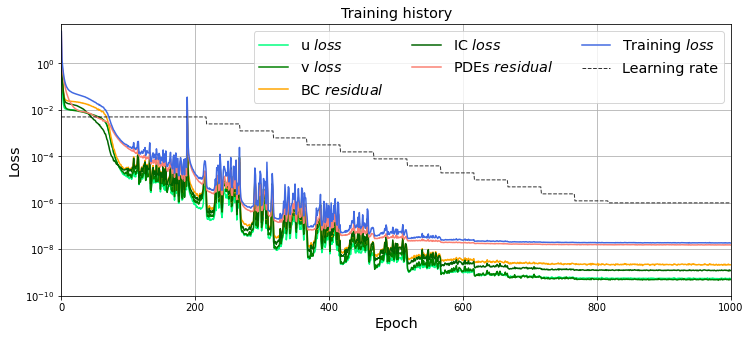

In [17]:
# plot loss history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(hist['epoch'], hist['u_loss'], label=r'u $loss$', alpha=1, c='springgreen');
plt.plot(hist['epoch'], hist['v_loss'], label=r'v $loss$', alpha=1, c='green');
plt.plot(hist['epoch'], hist['bc_loss'], label=r'BC $residual$', alpha=1, c='orange');
plt.plot(hist['epoch'], hist['ic_loss'], label=r'IC $loss$', alpha=1, c='darkgreen');
plt.plot(hist['epoch'], hist['pde_loss'], label=r'PDEs $residual$', alpha=1, c='salmon');
plt.plot(hist['epoch'], hist['loss'], label=r'Training $loss$', alpha=1, c='royalblue'); plt.yscale('log'); plt.grid();
plt.plot(hist['epoch'], hist['lr'], "k--", label=r'Learning rate', alpha=.8, linewidth=1);
plt.xlabel('Epoch', size='x-large'); plt.ylabel('Loss', size='x-large'); plt.xlim((0, EPOCH)); plt.ylim((1e-10, 5e1));
plt.title(r'Training history', fontsize="x-large"); plt.legend(fontsize='x-large', ncol=3);

In [18]:
# new prediction & error on [train] data
p_u, p_v, _, _, _, _, _ = eval_ins(X_train)

# mse
mse_u =  np.mean((p_u.flatten() - y_train[:, 0].flatten())**2)
mse_v =  np.mean((p_v.flatten() - y_train[:, 1].flatten())**2)
print ('mse u  = %.3e' %mse_u)
print ('mse v  = %.3e' %mse_v)

mse u  = 5.997e-10
mse v  = 4.651e-10


[t=0.00] mse u = 6.707e-10 , v = 6.055e-10
[t=0.20] mse u = 3.893e-10 , v = 3.690e-10
[t=0.40] mse u = 5.410e-10 , v = 4.160e-10
[t=0.60] mse u = 7.130e-10 , v = 4.005e-10
[t=0.80] mse u = 7.610e-10 , v = 6.166e-10
[t=1.00] mse u = 8.616e-10 , v = 7.924e-10


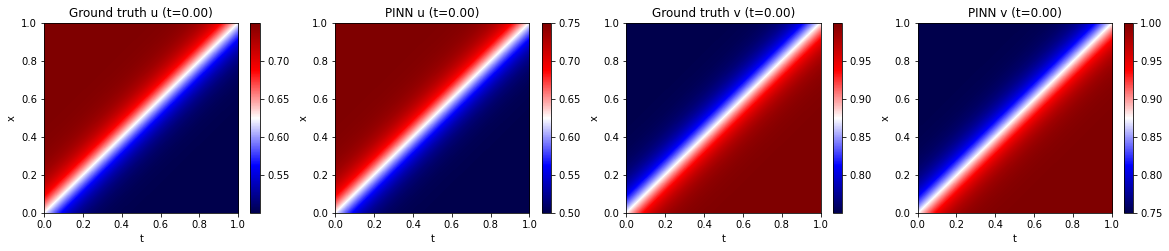

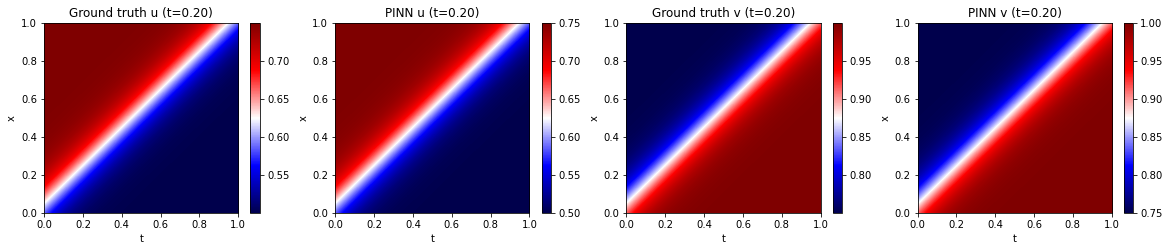

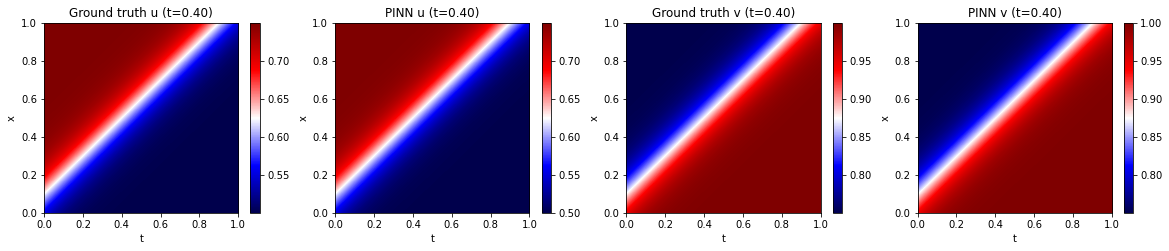

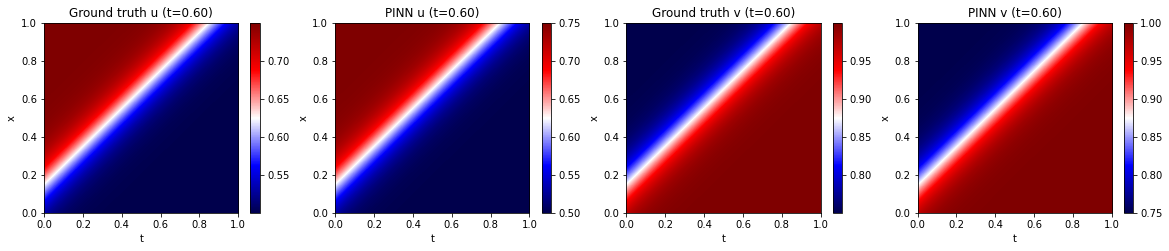

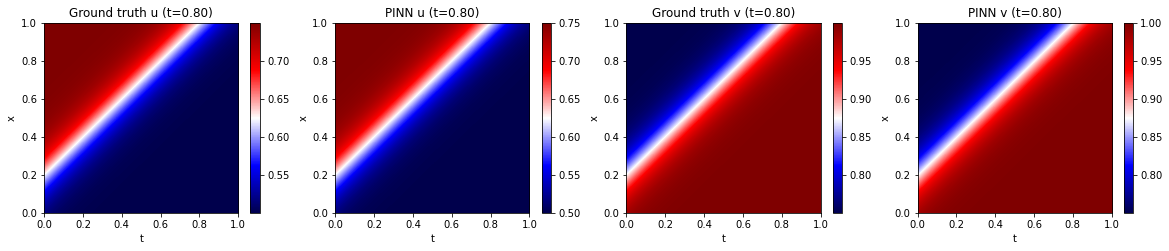

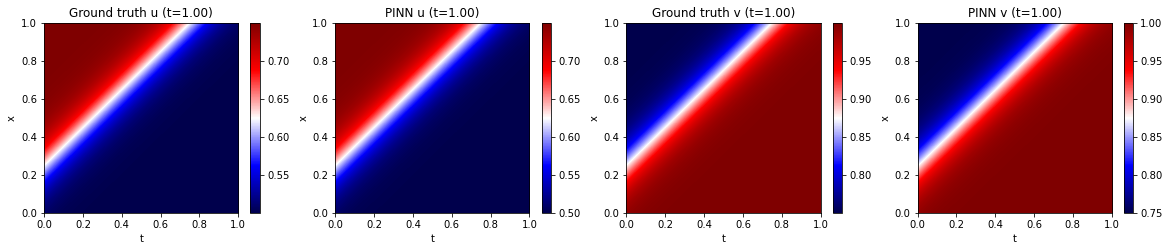

In [24]:
# new prediction & error on [train] data
for i in [0, 10, 20, 30, 40, 50]:
    t = ct[i]
    ix = (X_train[:, 0] == t)
    
    # mse
    mse_u =  np.mean((p_u[ix].flatten() - y_train[ix, 0].flatten())**2)
    mse_v =  np.mean((p_v[ix].flatten() - y_train[ix, 1].flatten())**2)
    print ('[t=%.2f] mse u = %.3e , v = %.3e' %(t, mse_u, mse_v))
    
    # plot solution
    fig = plt.figure(figsize=(20, 3.5))
    ax = plt.subplot(1, 4, 1)
    _u = y_train[ix, 0].reshape(n, n)
    plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='seismic', extent=ext, aspect='auto');
    plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('Ground truth u (t=%.2f)'%t);
    ax = plt.subplot(1, 4, 2)
    _u = p_u[ix].reshape(n, n)
    plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='seismic', extent=ext, aspect='auto');
    plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('PINN u (t=%.2f)'%t);    
    ax = plt.subplot(1, 4, 3)
    _v = y_train[ix, 1].reshape(n, n)
    plt.imshow(_v, interpolation='bilinear', origin='lower', cmap='seismic', extent=ext, aspect='auto');
    plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('Ground truth v (t=%.2f)'%t);
    ax = plt.subplot(1, 4, 4)
    _v = p_v[ix].reshape(n, n)
    plt.imshow(_v, interpolation='bilinear', origin='lower', cmap='seismic', extent=ext, aspect='auto');
    plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('PINN v (t=%.2f)'%t);